Epoch 1, Loss: 0.1689
Epoch 2, Loss: 0.1576
Epoch 3, Loss: 0.1286
Epoch 4, Loss: 0.1028
Epoch 5, Loss: 0.1733
Epoch 6, Loss: 0.1521
Epoch 7, Loss: 0.1405
Epoch 8, Loss: 0.1165
Epoch 9, Loss: 0.1824


Epoch 10, Loss: 0.0866


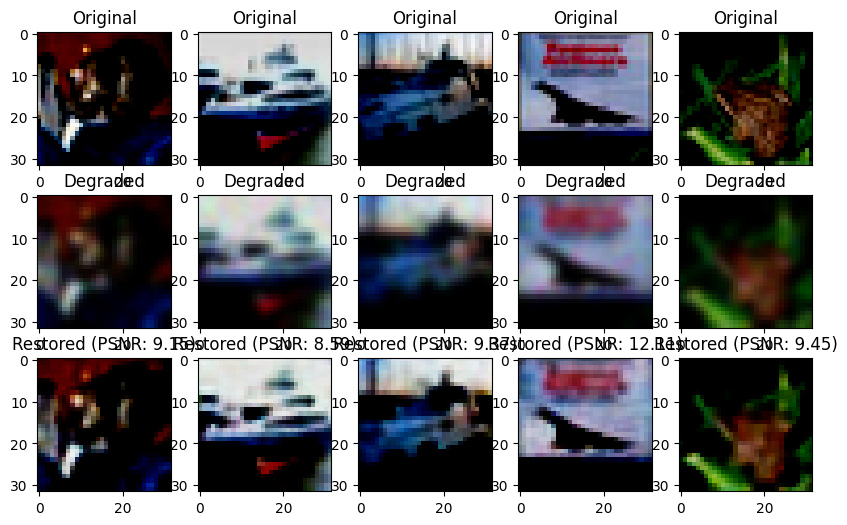

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

# Function to add noise and blur
def degrade_image(image):
    image = image.permute(1, 2, 0).numpy()
    noisy_image = image + np.random.normal(0, 0.1, image.shape)
    noisy_image = np.clip(noisy_image, 0, 1)
    blurred_image = cv2.GaussianBlur(noisy_image, (5, 5), 0)
    # Convert to float32 before creating the tensor
    return torch.tensor(blurred_image.astype(np.float32)).permute(2, 0, 1)

# Define Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1), nn.Sigmoid()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
for epoch in range(10):
    for images, _ in trainloader:
        degraded_images = torch.stack([degrade_image(img) for img in images])
        images, degraded_images = images.to(device), degraded_images.to(device)
        optimizer.zero_grad()
        outputs = model(degraded_images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Image Restoration & PSNR Evaluation
def psnr(original, restored):
    mse = np.mean((original - restored) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(1.0 / np.sqrt(mse))

model.eval()
dataiter = iter(testloader)
images, _ = next(dataiter)
degraded_images = torch.stack([degrade_image(img) for img in images])
images, degraded_images = images.to(device), degraded_images.to(device)
restored_images = model(degraded_images).cpu().detach().numpy()

# Display Results
fig, axs = plt.subplots(3, 5, figsize=(10, 6))
for i in range(5):
    axs[0, i].imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)))
    axs[0, i].set_title("Original")
    axs[1, i].imshow(np.transpose(degraded_images[i].cpu().numpy(), (1, 2, 0)))
    axs[1, i].set_title("Degraded")
    axs[2, i].imshow(np.transpose(restored_images[i], (1, 2, 0)))
    axs[2, i].set_title(f"Restored (PSNR: {psnr(images[i].cpu().numpy(), restored_images[i]):.2f})")
plt.show()
